# Imports

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time, glob, gc, os, tifffile, cv2
import pandas as pd
import seaborn as sns
import xarray as xr
import vima.data.ingest as vi

# Set up inputs to preprocessing

In [4]:
# parameters
resolution = 10 # desired size of each pixel in microns
nmetamarkers = 5
repname = f'pca_k={nmetamarkers}_harmony'

# data location
rootdir = '../../RA/BHAM-data'
outdir = f'{rootdir}/{resolution}u/'

# define markers and marker subsets
markers = ['DAPI', 'CLIC5', 'CD34', 'HLADR', 'CD3', 'CD90', 'CD68', 'AF']
real_markers = markers[:-1]
neg_ctrls = markers[-1:]

# define which files we will preprocess
sids = [f.split('/')[-1].split('.qptiff')[0]
        for f in glob.glob(f'{rootdir}/_qptiff/*.qptiff')]

In [5]:
# define how tissue is differentiated from background
def get_foreground(s):
    if s.name == '300-0529_Scan1':
        s = s.where(s.x < 12500, 0) # we manually remove part of this specific sample because of an
                                    # area of artifact so large that it skews our QC
    return vi.foreground_mask_ihc(s, real_markers, neg_ctrls, 0.1, 12, blur_width=5)

# define how pixel-level counts are normalized
def norm_by_AF(X):
    return (X[:,:-1]) / (1+X[:,-1])[:,None]

# compute dataset-wide summary statistics needed for the normalize function
# this function will be called on all the pixels in the dataset together; its output will
# then be passed to the normalize function when normalize is called on each sample
def get_sumstats(pixels):
    pixels = norm_by_AF(pixels)
    ntranscripts = pixels.sum(axis=1, dtype=np.float64)
    med_ntranscripts = np.median(ntranscripts)
    pixels = np.log1p(med_ntranscripts * pixels / (ntranscripts[:,None] + 1e-6)) # adding to denominator in case pixel is all 0s
    means = pixels.mean(axis=0, dtype=np.float64)
    stds = pixels.std(axis=0, dtype=np.float64)
    return {'means':means, 'stds':stds, 'med_ntranscripts':med_ntranscripts}

def normalize(mask, s, med_ntranscripts=None, means=None, stds=None):
    s = s.where(mask, other=0)
    pl = vi.xr_to_pixellist(s, mask)
    pl = norm_by_AF(pl)
    pl = np.log1p(med_ntranscripts * pl / (pl.sum(axis=1)[:,None] + 1e-6)) # adding to denominator in case pixel is all 0s
    pl -= means
    pl /= stds
    s = s.sel(marker=markers[:-1])
    vi.set_pixels(s, mask, pl)
    s.attrs['med_ntranscripts'] = med_ntranscripts
    s.attrs['means'] = means
    s.attrs['stds'] = stds
    return s

# Downsample original images and save in proper format

In [3]:
countsdir = f'{outdir}/counts'
os.makedirs(countsdir, exist_ok=True)
orig_pixel_size = 0.5
downsample_factor = int(resolution//orig_pixel_size)

In [4]:
for sid in vi.pb(sids):
    f = f'{rawdir}/{sid}.qptiff'
    sample = np.ascontiguousarray(tifffile.TiffFile(f).series[0].asarray().transpose(1,2,0))

    sample = vi.hiresarray_to_downsampledxarray(sample, sid, downsample_factor, orig_pixel_size, markers)
    sample.to_netcdf(f'{countsdir}/{sid}.nc', encoding={sample.name: vi.compression}, engine="netcdf4")
    
    gc.collect()

100%|███████████████████████████████████████████████████████████████| 27/27 [12:44<00:00, 28.30s/it]


# Pre-process

reading 300-0502_Scan1
132699 of 2498425 (5%) pixels are non-empty
reading 300-0307_Scan1
73001 of 3646489 (2%) pixels are non-empty
reading 300-0309_Scan3
60530 of 5375305 (1%) pixels are non-empty
reading 300-1933_Scan2
127740 of 5576785 (2%) pixels are non-empty
reading 300-0251_Scan1
9355 of 138985 (7%) pixels are non-empty
reading 300-0143_Scan1
43693 of 610225 (7%) pixels are non-empty
reading 300-0302_Scan2
168439 of 3902905 (4%) pixels are non-empty
reading 300-0145_Scan1
54308 of 1993537 (3%) pixels are non-empty
reading 300-0183_Scan1
75157 of 3003385 (3%) pixels are non-empty
reading 300-0504_Scan1
65611 of 2561065 (3%) pixels are non-empty
reading 300-2665_Scan1
94952 of 4600825 (2%) pixels are non-empty
reading 300-1934_Scan3
73568 of 5479201 (1%) pixels are non-empty
reading 300-0504_Scan2
62725 of 2491489 (3%) pixels are non-empty
reading 300-0529_Scan1
15316 of 3681025 (0%) pixels are non-empty
reading 300-0491_Scan1
148954 of 1765225 (8%) pixels are non-empty
reading 3

100%|███████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.54it/s]


computing sumstats
normalizing and writing


100%|███████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.70it/s]


...........................merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(3306822, 7)
performing PCA


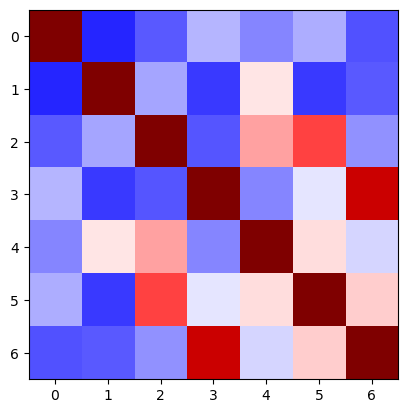

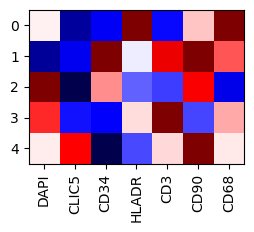

reading in pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.25it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


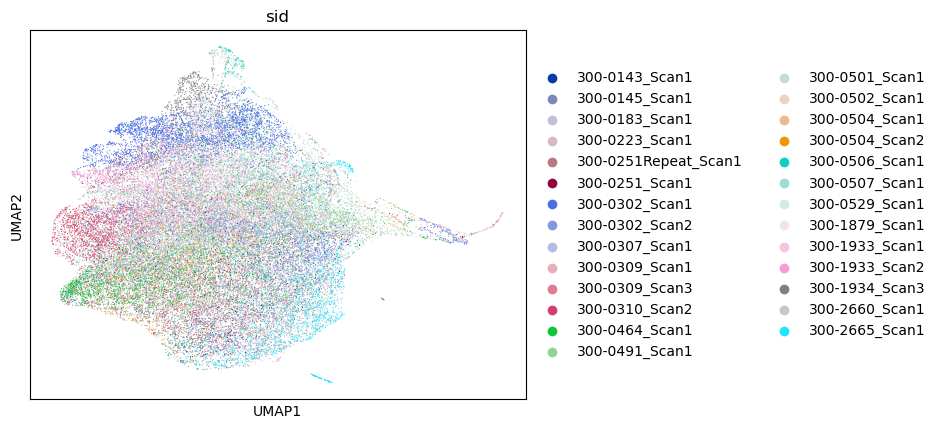

Please run the following command in your R environment:
Rscript /Users/yakir/Dropbox/py/vima/data/harmonize.R /Users/yakir/ST/RA/BHAM-data/10u/pca_k=5_harmony/_allpixels_pca.feather sid

When this finishes, run vi.post_harmony


In [6]:
# pre-harmony processing
vi.preprocess(outdir, repname, get_foreground, get_sumstats, normalize, nmetamarkers=nmetamarkers)

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


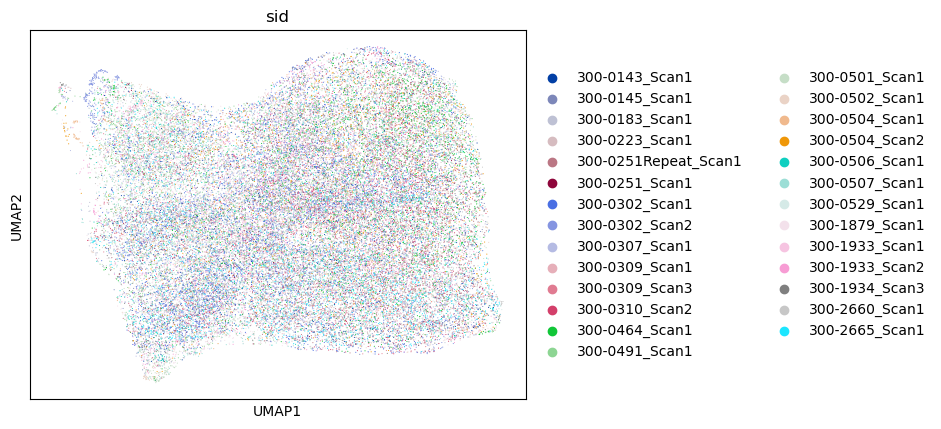

100%|███████████████████████████████████████████████████████████████| 27/27 [00:12<00:00,  2.12it/s]


In [7]:
# post-harmony processing
vi.post_harmony(outdir, repname, plot=True)

all PCs of one sample
histogram of each pc
01234

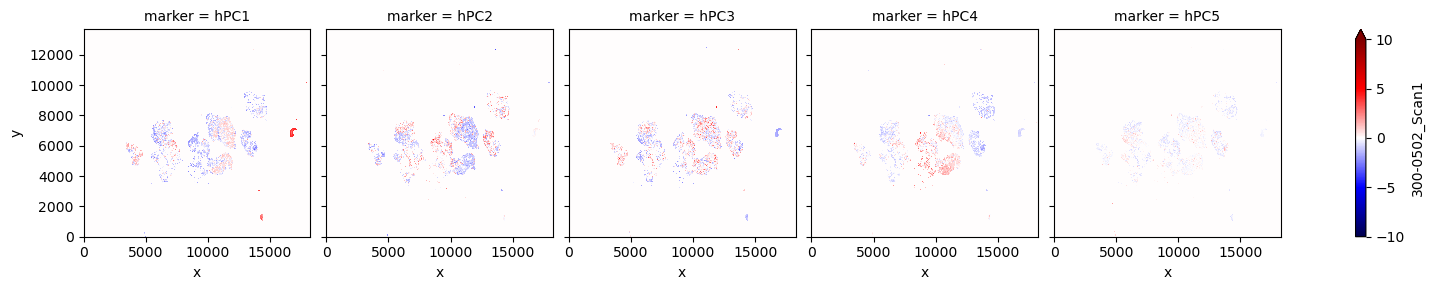

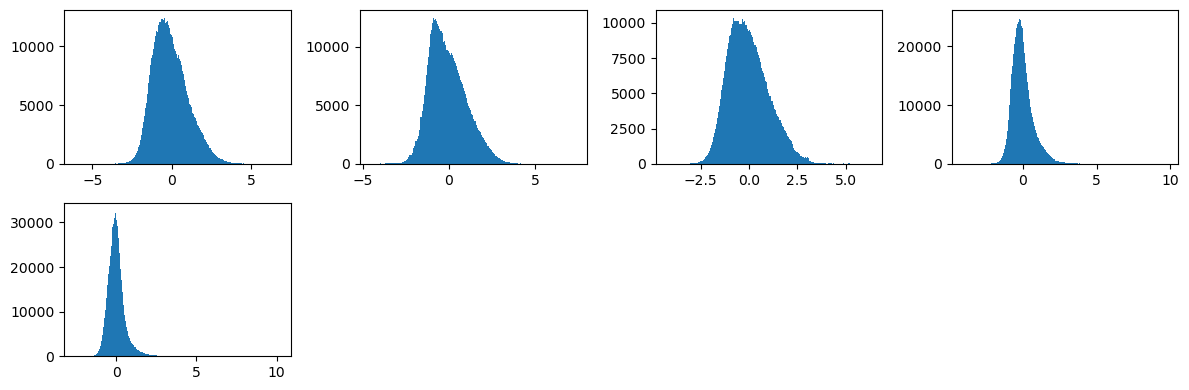

PC1 of several samples


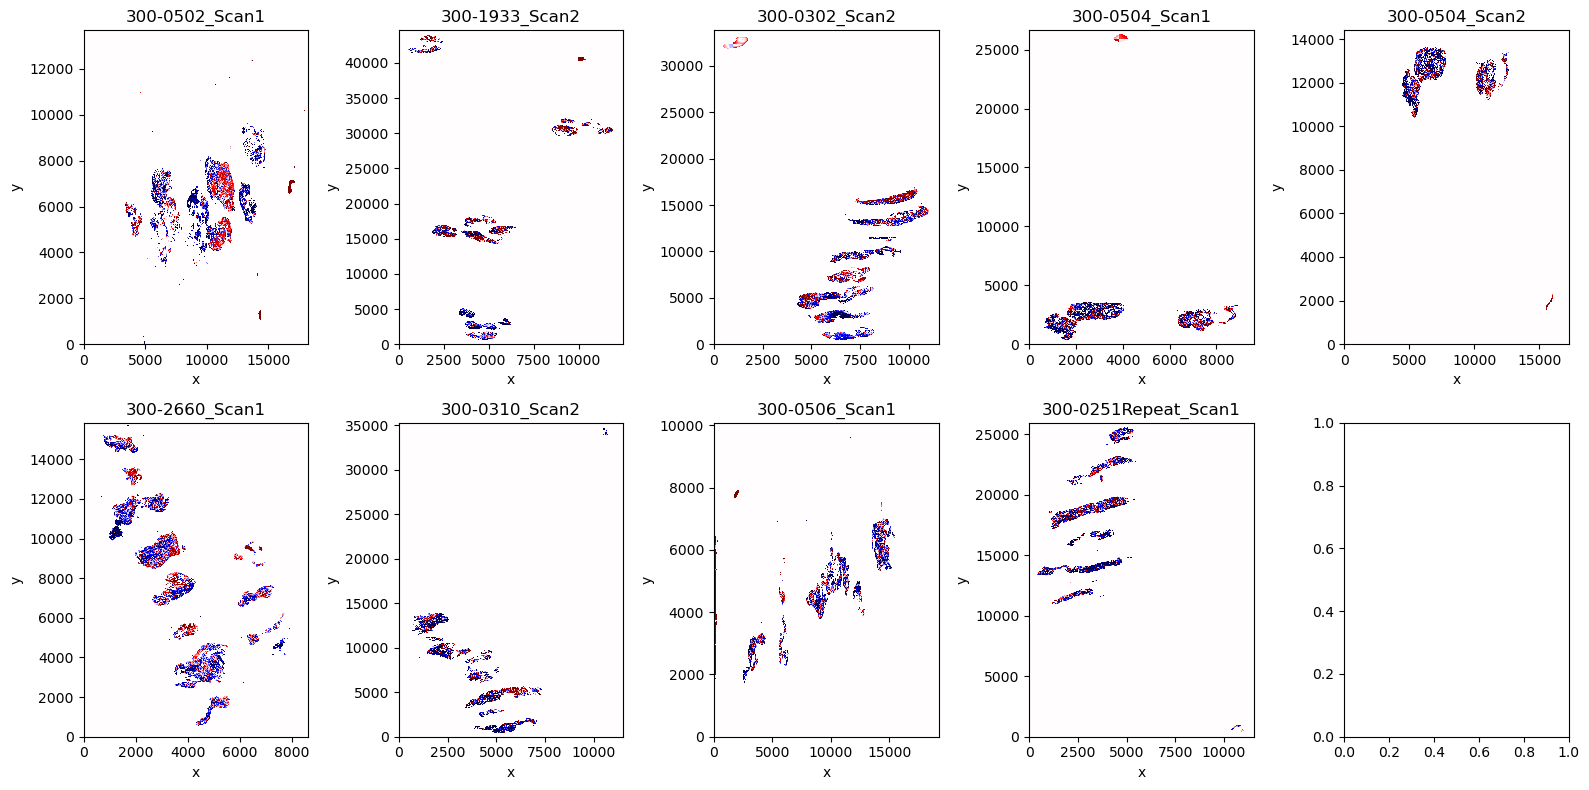

In [9]:
# visual sanity checks
vi.sanity_checks(outdir, repname)

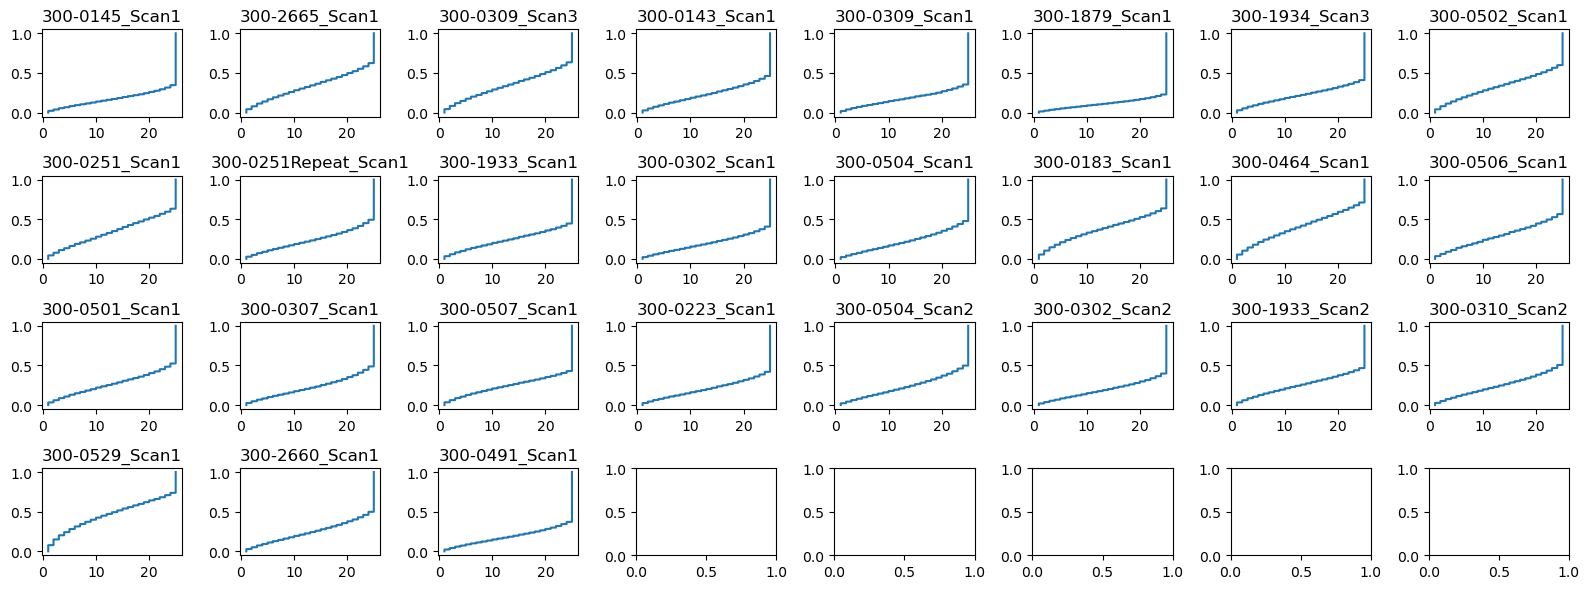

In [21]:
# create metapixels for more accurate PCA
metapixels, npixels = vi.metapixels_allsamples(normeddir, masksdir, sids)

merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(3306822, 7)
performing PCA


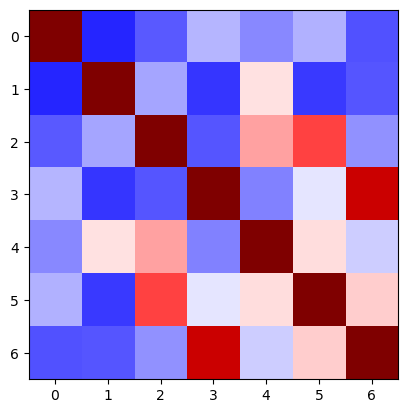

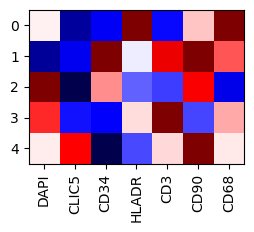

72430

In [22]:
# PCA the metapixels
loadings, C, allmp = vi.pca_metapixels(metapixels.values(), k)
loadings.to_feather(f'{processeddir}/_pcloadings.feather')
del metapixels, allmp; gc.collect()

reading in pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.37it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


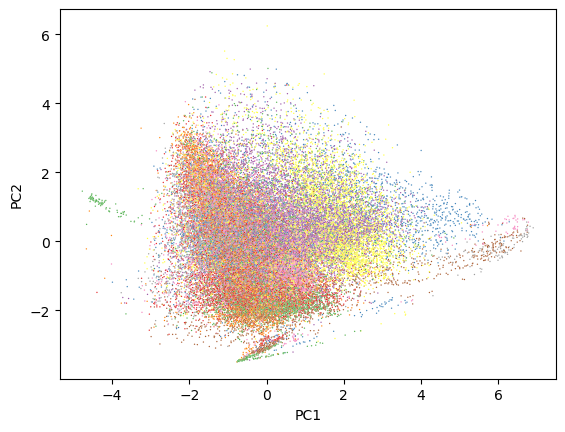

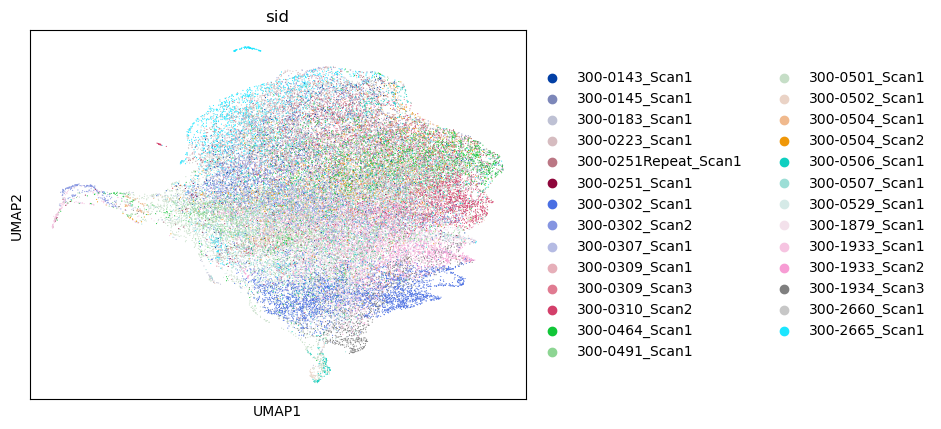

In [23]:
# apply the PC loadings to plain pixels
allpixels_pca = vi.pca_pixels(normeddir, masksdir,
                              pd.read_feather(f'{processeddir}/_pcloadings.feather'), sids)
allpixels_pca.to_feather(f'{processeddir}/_allpixels_pca.feather')

In [24]:
# run harmony
allpixels_pca = pd.read_feather(f'{processeddir}/_allpixels_pca.feather')
vi.harmonize(allpixels_pca, processeddir)

Please run the following command in your R environment:
Rscript /Users/yakir/Dropbox/py/tpae/data/harmonize.R /Users/yakir/ST/RA/BHAM-data/10u/pca_k=5_harmony/_allpixels_pca.feather sid


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


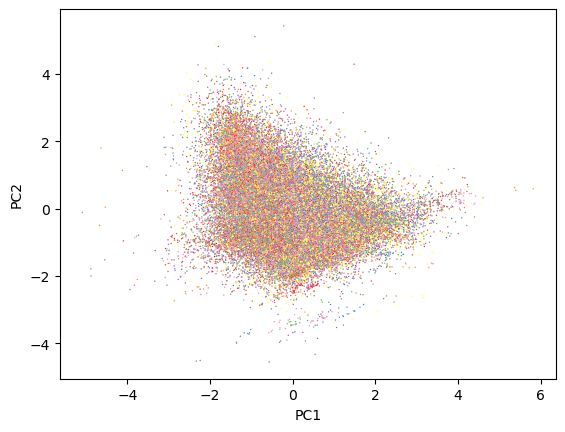

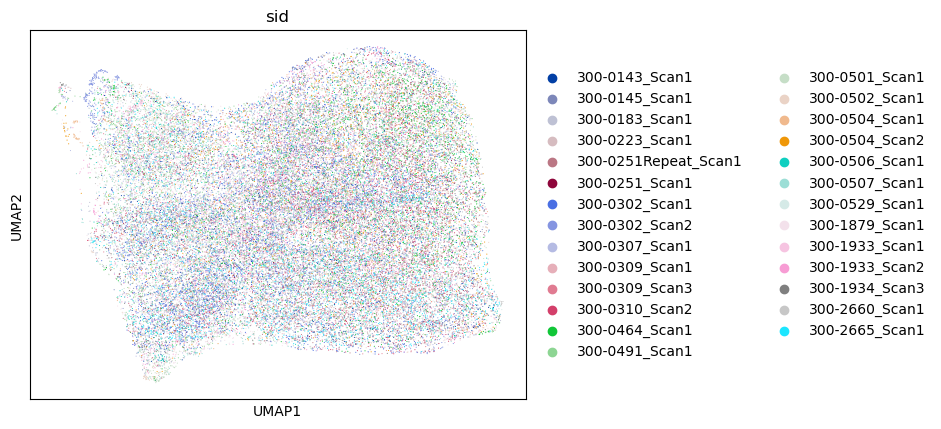

100%|███████████████████████████████████████████████████████████████| 27/27 [00:13<00:00,  2.01it/s]


In [25]:
# read in result and write individual samples
harmpixels = pd.read_feather(f'{processeddir}/_allpixels_pca_harmony.feather')
vi.visualize_pixels(harmpixels, 50000, ['sid'])
vi.write_harmonized(masksdir, processeddir, harmpixels, sids)

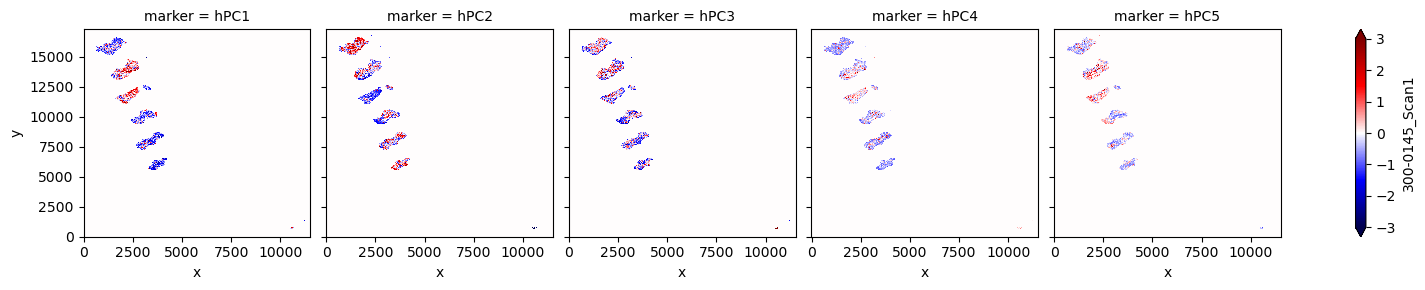

In [26]:
# all pcs of one sample
s = xr.open_dataarray(f'{processeddir}/{sids[0]}.nc').astype(np.float32)
s.plot(col='marker', col_wrap=5, vmin=-3, vmax=3, cmap='seismic')

01234

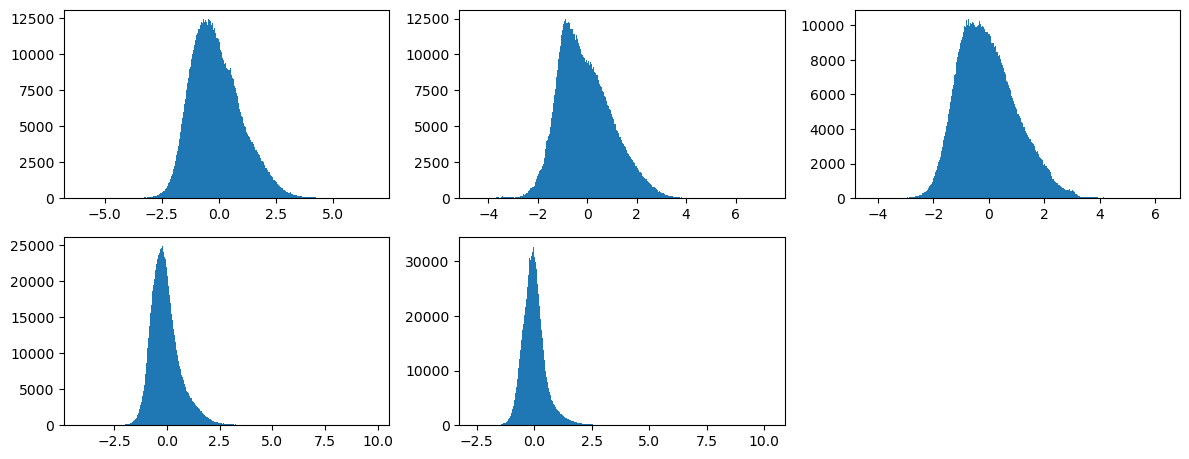

In [27]:
# histogram of each pc
harmpixels = pd.read_feather(f'{processeddir}/_allpixels_pca_harmony.feather')
plt.figure(figsize=(12,9))
for i in range(k):
    print(i, end='')
    plt.subplot(4, 3, i+1)
    plt.hist(harmpixels.values[:,i], bins=1000)
plt.tight_layout()
plt.show()

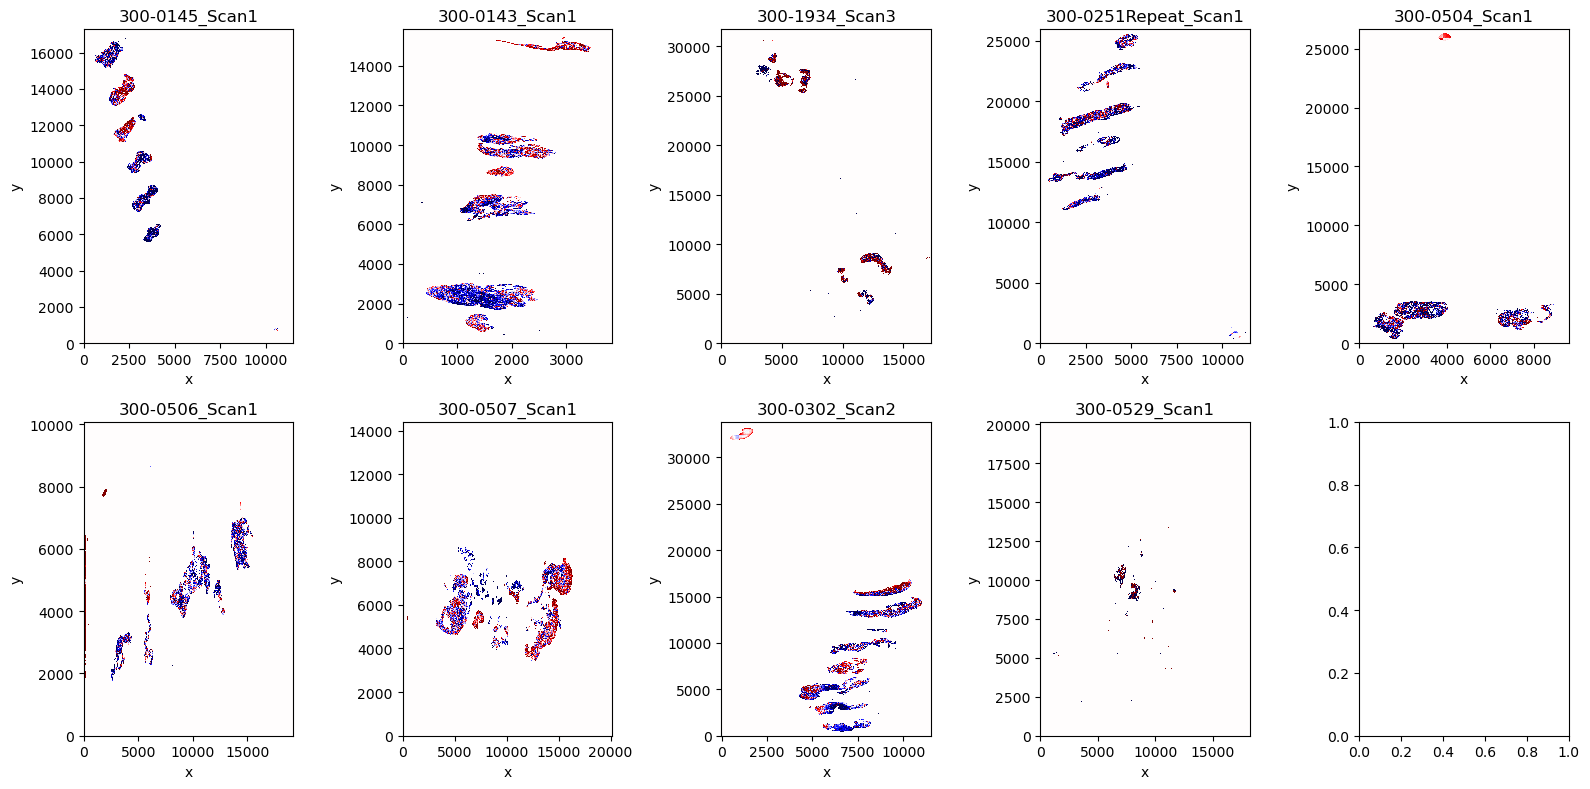

In [28]:
# PC1 of several samples
from IPython.display import display, clear_output
fig, axs = plt.subplots(len(sids[::5])//5 + 1, 5, figsize=(16, 4*(len(sids[::5])//5 + 1)))
for sid, ax in zip(sids[::3], axs.flatten()):
    s = xr.open_dataarray(f'{processeddir}/{sid}.nc').astype(np.float32)
    vmax = np.percentile(np.abs(s.sel(marker='hPC1').data), 99)
    s.sel(marker='hPC1').plot(ax=ax, cmap='seismic', vmin=-vmax, vmax=vmax, add_colorbar=False)
    ax.set_title(sid)
    plt.tight_layout(); clear_output(wait=True); display(fig)
    gc.collect()
plt.close()